# 클래스 활성화에 대한 히트맵 시각화
- Visualizing heat maps of class activation

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np


# The local path to our target image
img_path = '/content/creative_commons_elephant.jpg'


# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))


# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)


# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)


# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [19]:
# 예측
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted: [('n09229709', 'bubble', 0.34082106), ('n03888257', 'parachute', 0.10170846), ('n03598930', 'jigsaw_puzzle', 0.08798944)]


In [20]:
np.argmax(preds[0])

971

In [22]:
# Grad-CAM 알고리즘 설정

from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [23]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis=-1)

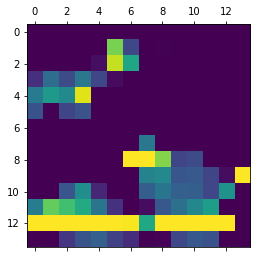

In [24]:
# Heatmap post-processing
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap, 0)
plt.matshow(heatmap)

In [25]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/content/creative_commons_elephant_cam.jpg', superimposed_img)

True

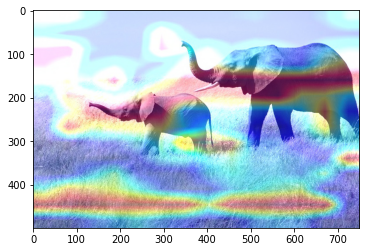

In [26]:
import matplotlib.image as img

image = img.imread('/content/creative_commons_elephant_cam.jpg')
plt.imshow(image)
plt.show()